# Retail Store Performance Analysis

In [1]:
import sqlite3
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from viz_helpers import (
    SITE_BG,
    SURFACE_COLOR,
    SURFACE_ACCENT,
    PRIMARY_COLOR,
    SECONDARY_COLOR,
    ACCENT_COLOR,
    TEXT_COLOR,
    TEXT_MUTED,
    BORDER_COLOR,
    GRID_COLOR,
    configure_matplotlib,
    apply_axes_theme,
    style_legend,
    currency_formatter,
    integer_formatter,
    percent_formatter,
    decimal_formatter,
)

configure_matplotlib()



'DejaVu Sans'

In [2]:
# Path to the SQLite database built from the CSV files
conn_path = Path("data/target_packaging.db").resolve()


In [3]:
# Function to run queries through the SQLite database
def run_sql(query, params=None, db_path=conn_path):
    params = params or ()
    try:
        conn = sqlite3.connect(db_path)
        conn.execute("PRAGMA temp_store = MEMORY;")
        cursor = conn.cursor()
        cursor.execute(query, params)

        if cursor.description is not None:
            columns = [column[0] for column in cursor.description]
            rows = cursor.fetchall()
            if rows:
                df = pd.DataFrame(rows, columns=columns)
                return df
            print("The query returned no results.")
        else:
            conn.commit()
            print("Query executed successfully.")

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        try:
            cursor.close()
        except NameError:
            pass
        if 'conn' in locals():
            conn.close()


## Queries

### 1. Which store format has the highest average security incidents per store?

#### Objective:
To identify which store format experiences the highest average security incidents per store. This information could be crucial for decision-makers considering adjustments to security measures.

#### SQL Code:

In [4]:
query = """
SELECT 
    SI.store_format AS Store_Format,
    AVG(TC.security_incident_count) AS Avg_Security_Incidents
FROM 
    csv_cleaned__store_information_csv AS SI 
    INNER JOIN csv_cleaned__trucase_incidents_csv AS TC ON SI.store = TC.store_t_number
GROUP BY 
    SI.store_format
ORDER BY 
    Avg_Security_Incidents DESC
LIMIT 5;
"""
df_query_1 = run_sql(query)


#### Output:
StoreFormat_47 has by far the highest average at 14 incidents per store followed by StoreFormat_03 at 3 incidents per store and StoreFormat_36 at 2 incidents per store.

In [5]:
df_query_1

,Store_Format,Avg_Security_Incidents
0,StoreFormat_47,14.600000
1,StoreFormat_03,3.075198
2,StoreFormat_36,2.897153
3,StoreFormat_25,1.933590
4,StoreFormat_40,1.805147


#### Visualization:

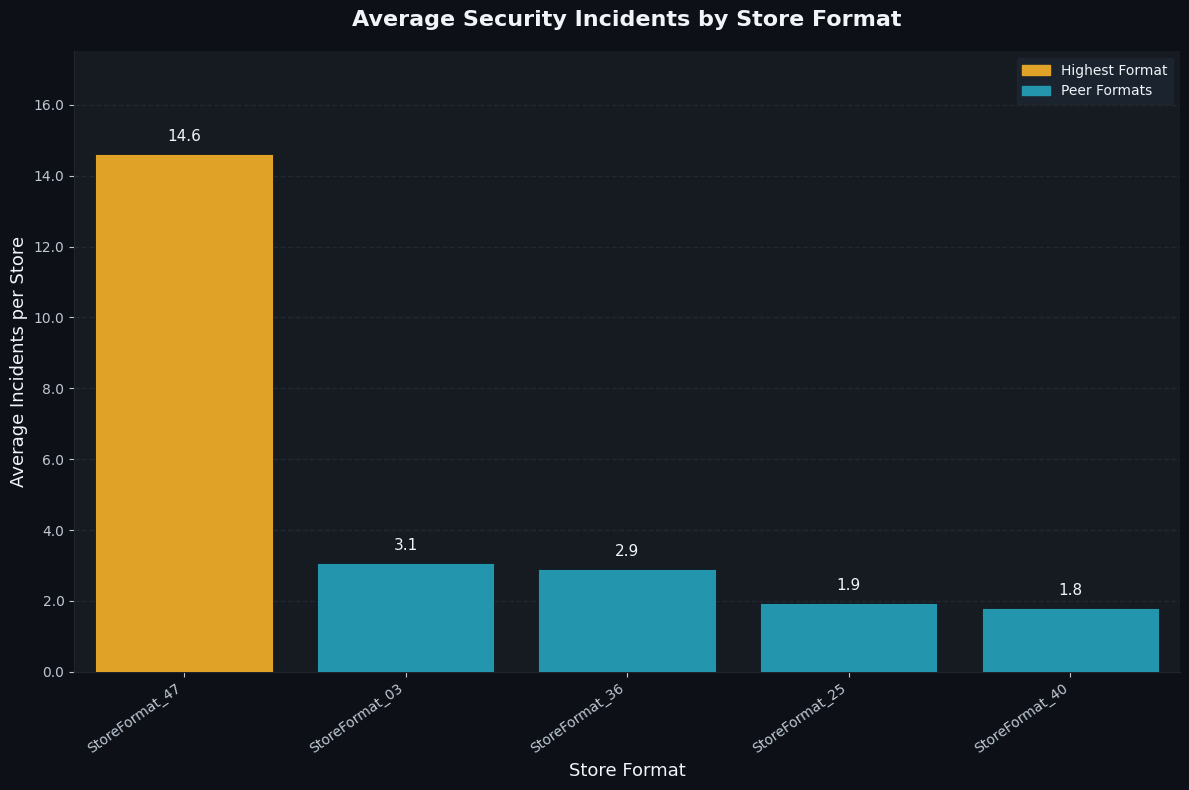

In [6]:
# Plot average incidents by store format
plot_data = df_query_1.sort_values("Avg_Security_Incidents", ascending=False).reset_index(drop=True)
color_map = [ACCENT_COLOR] + [PRIMARY_COLOR] * (len(plot_data) - 1)

fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
fig.patch.set_facecolor(SITE_BG)
apply_axes_theme(ax)
ax.grid(axis="y", linestyle="--", linewidth=1.0, alpha=0.5)

bars = ax.bar(
    plot_data["Store_Format"],
    plot_data["Avg_Security_Incidents"],
    color=color_map,
    edgecolor="#101820",
    linewidth=0.6,
    zorder=3,
)

ax.set_title("Average Security Incidents by Store Format", pad=18)
ax.set_xlabel("Store Format")
ax.set_ylabel("Average Incidents per Store")
ax.set_ylim(0, plot_data["Avg_Security_Incidents"].max() * 1.2)
ax.margins(x=0.02)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.1f}"))

for label in ax.get_xticklabels():
    label.set_rotation(35)
    label.set_horizontalalignment("right")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + plot_data["Avg_Security_Incidents"].max() * 0.02,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=11,
        color=TEXT_COLOR,
    )

legend_handles = [
    mpatches.Patch(color=ACCENT_COLOR, label="Highest Format"),
    mpatches.Patch(color=PRIMARY_COLOR, label="Peer Formats"),
]
style_legend(ax.legend(handles=legend_handles, loc="upper right"))

plt.tight_layout()
plt.show()


#### Analysis:
Based on the data, we can see that StoreFormat_47 has by far the highest average security incidents per store. This information could be used to allocate more security resources to StoreFormat_47 stores.

### 2. Which states have the highest average recorded daily theft?

#### Objective:
To determine which states have the highest average recorded daily theft. Understanding this can help regional managers focus their loss prevention efforts.

#### SQL Code:

In [7]:
query = """
SELECT 
    SI.state AS State, 
    ROUND((SUM(TC.total_theft_proven) / COUNT(TC.incident_month_year)) / 30.0, 2) AS Average_Daily_Theft
FROM 
    csv_cleaned__trucase_incidents_csv AS TC 
    INNER JOIN csv_cleaned__store_information_csv AS SI ON TC.store_t_number = SI.store
GROUP BY 
    SI.state
ORDER BY 
    Average_Daily_Theft DESC
LIMIT 10;
"""
df_query_2 = run_sql(query)


#### Output:
State_38 has the highest daily theft at $991.13 per store per day followed by State_03 and State_20.

In [8]:
df_query_2

,State,Average_Daily_Theft
0,State_38,991.13
1,State_03,802.19
2,State_20,796.59
3,State_41,794.43
4,State_26,771.40
5,State_21,584.47
6,State_30,551.42
7,State_34,512.40
8,State_14,488.16
9,State_24,448.99


#### Visualization:

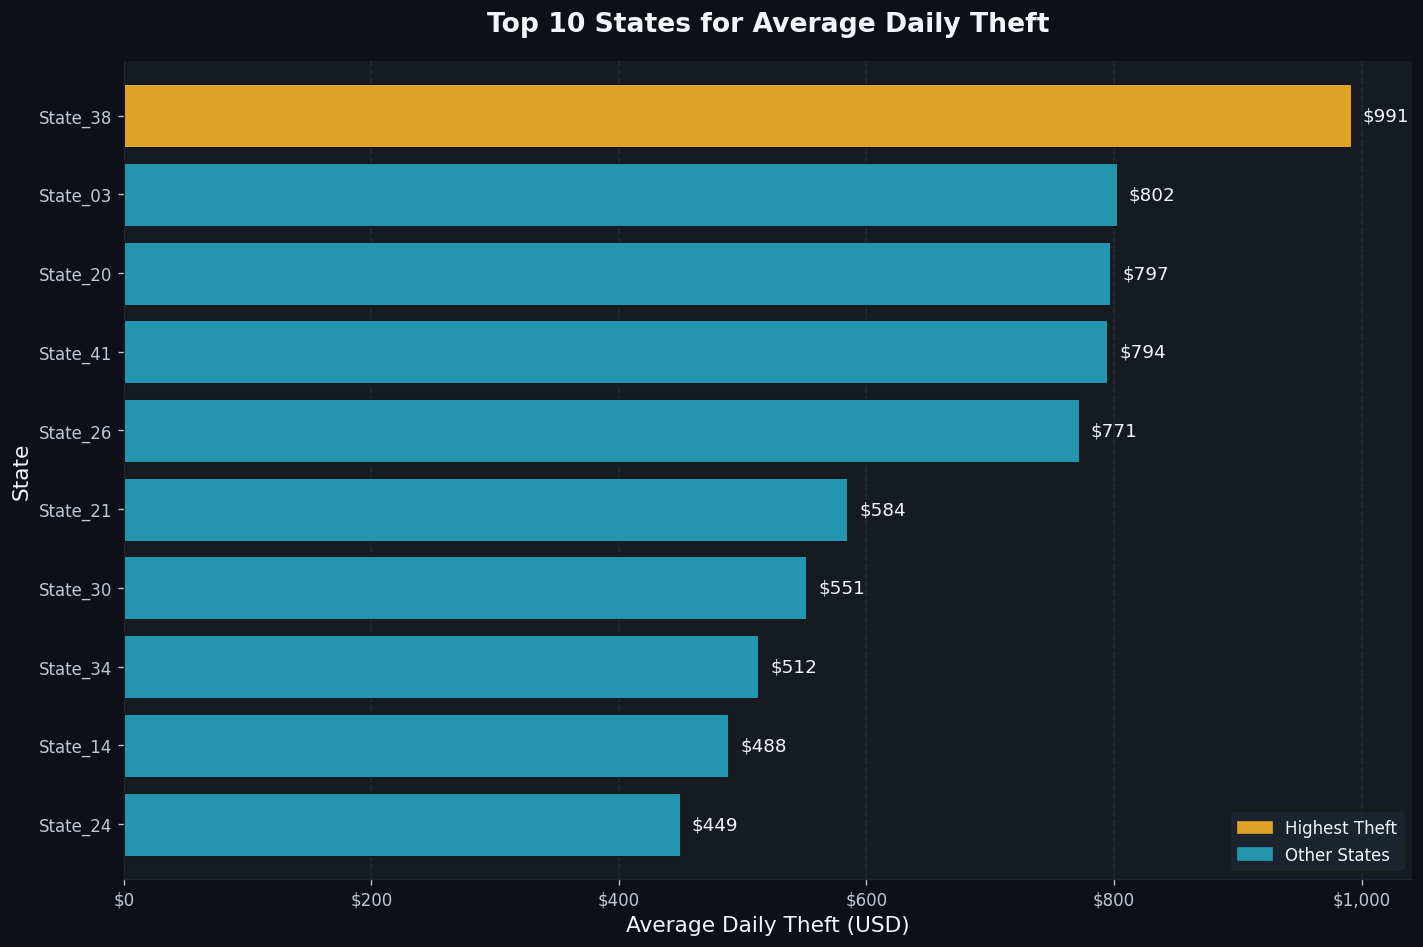

In [9]:
# Plot top states by average daily theft
plot_data = df_query_2.sort_values("Average_Daily_Theft", ascending=True).reset_index(drop=True)
color_map = [PRIMARY_COLOR] * (len(plot_data) - 1) + [ACCENT_COLOR]

fig, ax = plt.subplots(figsize=(12, 8), dpi=120)
fig.patch.set_facecolor(SITE_BG)
apply_axes_theme(ax)
ax.grid(axis="x", linestyle="--", linewidth=1.0, alpha=0.5)

bars = ax.barh(
    plot_data["State"],
    plot_data["Average_Daily_Theft"],
    color=color_map,
    edgecolor="#101820",
    linewidth=0.6,
    zorder=3,
)

ax.set_title("Top 10 States for Average Daily Theft", pad=18)
ax.set_xlabel("Average Daily Theft (USD)")
ax.set_ylabel("State")
ax.xaxis.set_major_formatter(currency_formatter())
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.margins(y=0.03)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + plot_data["Average_Daily_Theft"].max() * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=11,
        color=TEXT_COLOR,
    )

legend_handles = [
    mpatches.Patch(color=ACCENT_COLOR, label="Highest Theft"),
    mpatches.Patch(color=PRIMARY_COLOR, label="Other States"),
]
style_legend(ax.legend(handles=legend_handles, loc="lower right"))

plt.tight_layout()
plt.show()


#### Analysis:
The states with the highest average recorded daily theft are State_38, State_03, and State_20. Loss prevention initiatives might be more effectively focused on stores in these states.

### 3. Has the recent boycott actually affected our store?

#### Objective:
To assess the impact of a recent boycott campaign on our stores by comparing sales data before and after the boycott started.

#### SQL Code:

In [10]:
query = """
WITH parsed AS (
    SELECT
        CAST(substr(sale_week, length(sale_week) - 3, 4) AS INTEGER) AS year_value,
        CAST(substr(sale_week, 1, instr(sale_week, '/') - 1) AS INTEGER) AS month_value,
        sales
    FROM csv_cleaned__sales_2343_csv
    WHERE sale_week LIKE '%/%/%'
), bounds AS (
    SELECT MAX(year_value) AS max_year
    FROM parsed
), filtered AS (
    SELECT
        p.year_value,
        p.month_value,
        ROUND(SUM(p.sales), 2) AS total_sales
    FROM parsed p
    CROSS JOIN bounds b
    WHERE p.month_value BETWEEN 5 AND 7
      AND p.year_value BETWEEN b.max_year - 2 AND b.max_year
    GROUP BY p.year_value, p.month_value
)
SELECT 
    year_value AS Year,
    month_value AS Month,
    total_sales AS Total_Sales
FROM filtered
ORDER BY Month ASC, Year ASC;
"""
df_query_3 = run_sql(query)



#### Output:
2023 has the lowest sales total over all three tracked years for the months of May, June, and July.

In [11]:
df_query_3

,Year,Month,Total_Sales
0,2021,5,2575229.18
1,2022,5,2499580.99
2,2023,5,1782920.42
3,2021,6,2286855.56
4,2022,6,2113931.31
5,2023,6,1868838.56
6,2021,7,2183358.84
7,2022,7,2736213.53
8,2023,7,1089515.23


#### Visualization:

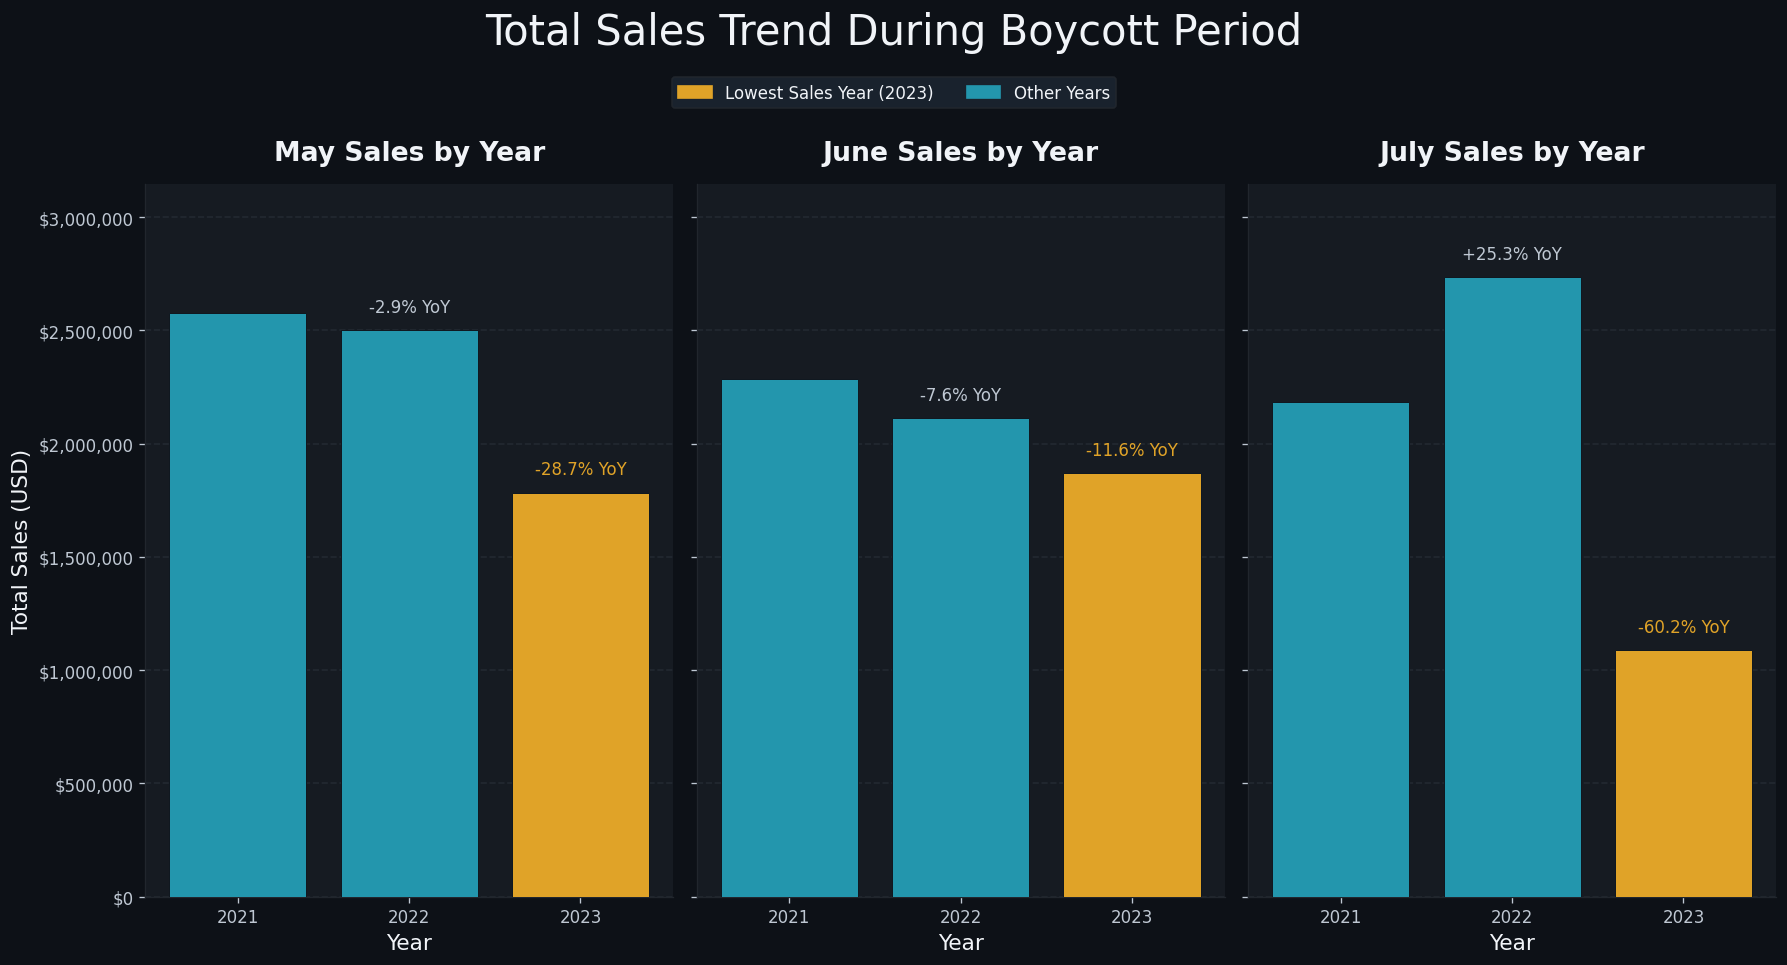

In [12]:
# Visualize total sales trend for boycott analysis
month_name_map = {5: "May", 6: "June", 7: "July"}
plot_months = sorted(df_query_3["Month"].unique())
all_years = sorted(df_query_3["Year"].unique())

fig, axes = plt.subplots(1, len(plot_months), figsize=(15, 8), dpi=120, sharey=True)
fig.patch.set_facecolor(SITE_BG)
max_sales = df_query_3["Total_Sales"].max() * 1.15

highlight_year = max(all_years)

for idx, (month, ax) in enumerate(zip(plot_months, axes)):
    apply_axes_theme(ax)
    ax.grid(axis="y", linestyle="--", linewidth=1.0, alpha=0.5)

    month_data = (
        df_query_3[df_query_3["Month"] == month]
        .sort_values("Year")
        .reset_index(drop=True)
        .copy()
    )
    month_data["YoY Change"] = month_data["Total_Sales"].pct_change() * 100

    colors = [ACCENT_COLOR if year == highlight_year else PRIMARY_COLOR for year in month_data["Year"]]
    bars = ax.bar(
        month_data["Year"].astype(str),
        month_data["Total_Sales"],
        color=colors,
        edgecolor="#101820",
        linewidth=0.6,
        zorder=3,
    )

    month_name = month_name_map.get(month, f"Month {month}")
    ax.set_title(f"{month_name} Sales by Year", pad=14)
    ax.set_xlabel("Year")
    if idx == 0:
        ax.set_ylabel("Total Sales (USD)")
    ax.set_ylim(0, max_sales)
    ax.yaxis.set_major_formatter(currency_formatter())

    for bar, yoy, color in zip(bars, month_data["YoY Change"], colors):
        if np.isnan(yoy):
            continue
        text_color = ACCENT_COLOR if color == ACCENT_COLOR else TEXT_MUTED
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max_sales * 0.02,
            f"{yoy:+.1f}% YoY",
            ha="center",
            va="bottom",
            fontsize=10,
            color=text_color,
        )

legend_handles = [
    mpatches.Patch(color=ACCENT_COLOR, label=f"Lowest Sales Year ({highlight_year})"),
    mpatches.Patch(color=PRIMARY_COLOR, label="Other Years"),
]
fig.suptitle("Total Sales Trend During Boycott Period", y=1, fontsize=25)
style_legend(fig.legend(handles=legend_handles, loc="upper center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 0.94)))

plt.tight_layout()
plt.subplots_adjust(top=0.82)
plt.show()


#### Analysis:
Sales have gradually been dropping year-over-year but drastically dropped in 2023. In May, the year-over-year drop by percentage was 28.7%, for June it was 11.6%, and for July it was a staggering 60.2% drop. If the question is "Did the boycott have any change in sales?", the answer seems to be yes.

### 4. Which employees have reported the most empty packages in the current month?

#### Objective:
To identify the employees who have reported the most empty packages in the current month. This could help in internal training and awareness programs.

#### SQL Code:

In [13]:
query = """
WITH parsed AS (
    SELECT
        reported_by_id,
        dpci,
        quantity,
        CAST(substr(reported_date, 1, instr(reported_date, '/') - 1) AS INTEGER) AS month_value,
        CAST(substr(substr(reported_date, instr(reported_date, '/') + 1), 1, instr(substr(reported_date, instr(reported_date, '/') + 1), '/') - 1) AS INTEGER) AS day_value,
        CAST(substr(reported_date, length(reported_date) - 3, 4) AS INTEGER) AS year_value
    FROM csv_cleaned__empty_packages_2343_old_csv
    WHERE reported_date LIKE '%/%/%'
), latest AS (
    SELECT year_value, month_value
    FROM parsed
    ORDER BY year_value DESC, month_value DESC, day_value DESC
    LIMIT 1
), filtered AS (
    SELECT p.*
    FROM parsed p
    CROSS JOIN latest l
    WHERE p.year_value = l.year_value AND p.month_value = l.month_value
), aggregates AS (
    SELECT
        EI.employee_id,
        ROUND(SUM(COALESCE(DI.official_retail_price, 0) * filtered.quantity), 2) AS Retail_Price_Sum,
        SUM(filtered.quantity) AS Number_of_Items
    FROM filtered
    INNER JOIN csv_cleaned__employee_info_2343_csv AS EI ON filtered.reported_by_id = EI.employee_id
    LEFT JOIN csv_cleaned__dpci_info_old_csv AS DI ON filtered.dpci = DI.dpci_orig
    GROUP BY EI.employee_id
)
SELECT
    employee_id AS Employee_ID,
    Retail_Price_Sum,
    Number_of_Items
FROM aggregates
ORDER BY Retail_Price_Sum DESC
LIMIT 10;
"""
df_query_4 = run_sql(query)


#### Output:
EmployeeID_231 has the highest total retail price of $285.96, followed by EmployeeID_098 and EmployeeID_196.

In [14]:
df_query_4

,Employee_ID,Retail_Price_Sum,Number_of_Items
0,EmployeeID_231,291.06,24
1,EmployeeID_098,165.98,2
2,EmployeeID_196,130.43,11
3,EmployeeID_147,111.98,7
4,EmployeeID_109,104.98,2
5,EmployeeID_018,83.00,6
6,EmployeeID_220,69.99,5
7,EmployeeID_067,68.96,7
8,EmployeeID_178,64.97,4
9,EmployeeID_187,58.97,5


#### Visualization:

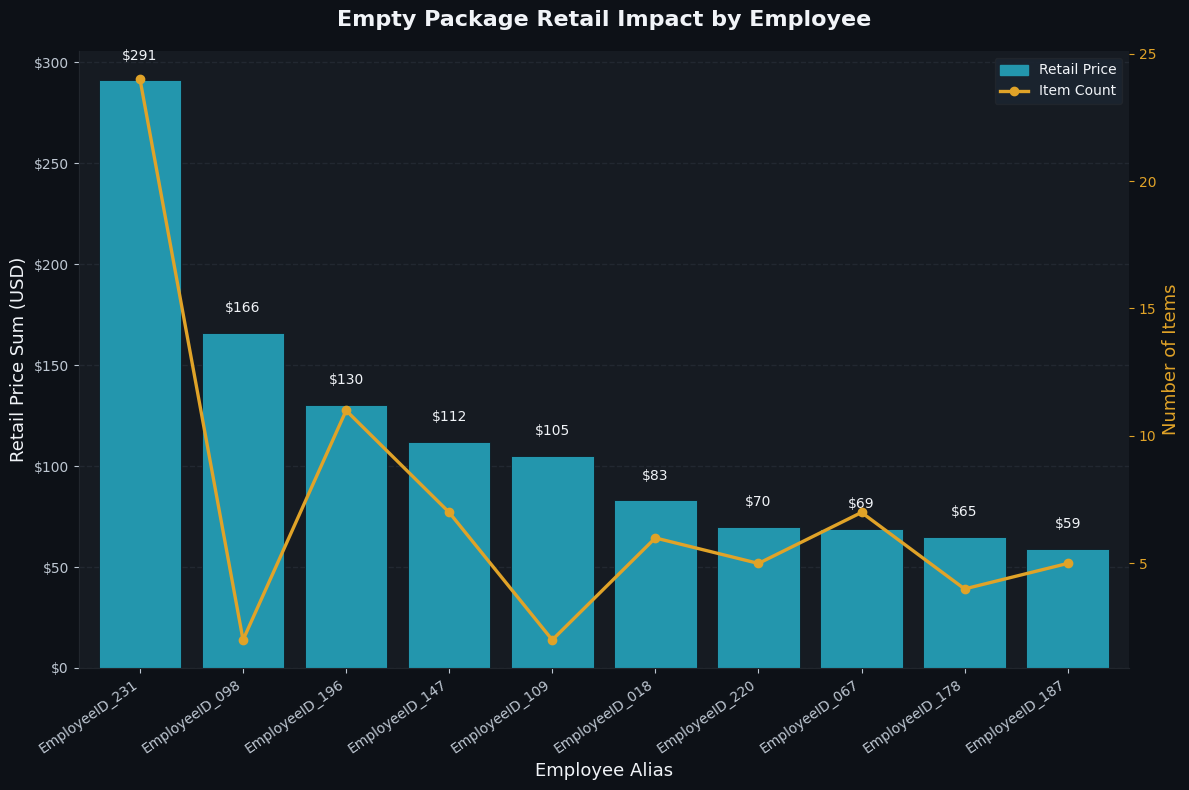

In [15]:
# Empty package impact by employee
plot_data = df_query_4.sort_values("Retail_Price_Sum", ascending=False).reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 8), dpi=100)
fig.patch.set_facecolor(SITE_BG)
apply_axes_theme(ax1)
ax1.grid(axis="y", linestyle="--", linewidth=1.0, alpha=0.5)

bars = ax1.bar(
    plot_data["Employee_ID"],
    plot_data["Retail_Price_Sum"],
    color=PRIMARY_COLOR,
    edgecolor="#101820",
    linewidth=0.6,
    zorder=3,
)
ax1.set_xlabel("Employee Alias")
ax1.set_ylabel("Retail Price Sum (USD)")
ax1.yaxis.set_major_formatter(currency_formatter())
ax1.margins(x=0.02)

for label in ax1.get_xticklabels():
    label.set_rotation(35)
    label.set_horizontalalignment("right")

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + plot_data["Retail_Price_Sum"].max() * 0.03,
        f"${height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color=TEXT_COLOR,
    )

ax2 = ax1.twinx()
ax2.set_facecolor(SURFACE_COLOR)
ax2.spines["right"].set_color(BORDER_COLOR)
ax2.tick_params(axis="y", colors=ACCENT_COLOR)
line, = ax2.plot(
    plot_data["Employee_ID"],
    plot_data["Number_of_Items"],
    color=ACCENT_COLOR,
    marker="o",
    linewidth=2.4,
    markersize=6,
    zorder=4,
    label="Number of Items",
)
ax2.set_ylabel("Number of Items", color=ACCENT_COLOR)
ax2.margins(x=0.02)

ax1.set_title("Empty Package Retail Impact by Employee", pad=18)
legend_handles = [
    mpatches.Patch(color=PRIMARY_COLOR, label="Retail Price"),
    Line2D([0], [0], color=ACCENT_COLOR, marker="o", linewidth=2.4, label="Item Count"),
]
style_legend(ax1.legend(handles=legend_handles, loc="upper right"))

plt.tight_layout()
plt.show()


#### Analysis:
Employees 231, 098, and 196 have reported the most empty packages for the current month, suggesting they are vigilant or perhaps their sections are more prone to theft or loss. It is interesting to see that the second highest retail sum but only have two items recorded meaning a much higher average cost per item. This could be worth investigating.

## Stored Procedures

### Retrieve specific employee information (SQLite helper)


#### Objective:
Provide a lightweight equivalent to the previous stored procedure using SQLite-compatible code.


#### Implementation:


In [16]:
# Helper to mimic the stored procedure behavior in SQLite
def get_employee_details(employee_id):
    return run_sql(
        """
        SELECT *
        FROM csv_cleaned__employee_info_2343_csv
        WHERE employee_id = ?;
        """,
        params=(employee_id,)
    )

#### Usage:
Call `get_employee_details(<employee_id>)` to look up a record from the SQLite database.


In [17]:
df_stored_procedure = get_employee_details("EmployeeID_203")

#### Output:
This shows a single employee's information.

In [18]:
df_stored_procedure

,store_t_number,employee_id,original_hire_date,termination_date,first_name,middle_name,last_name,preferred_full_name,preferred_first_name,email,probation_y_n,minor_y_n,job_description,job_department,position_id,reports_to_position_id
0,Store_8353,EmployeeID_203,6/28/2023,None,FirstName_0001,MiddleName_0001,LastName_0001,EmployeeName_036,PreferredFirstName_0202,None,ProbationYN_0001,None,JobDescription_37,JobDepartment_5,PositionID_159,ReportsToPositionId_0001


## Views

### Create a view to pull recent return divisions

#### Objective:
To provide an easy way to see the categories of items that are most frequently returned, aiding in quality control and inventory management.

#### SQL Code:

In [19]:
run_sql("DROP VIEW IF EXISTS recent_return_divisions;")


Query executed successfully.


In [20]:
run_sql("""
CREATE VIEW recent_return_divisions AS
WITH parsed AS (
    SELECT
        division_name,
        department_name,
        CAST("return" AS REAL) AS return_value,
        return_units,
        CAST(substr(sale_week, 1, instr(sale_week, '/') - 1) AS INTEGER) AS month_value,
        CAST(substr(substr(sale_week, instr(sale_week, '/') + 1), 1, instr(substr(sale_week, instr(sale_week, '/') + 1), '/') - 1) AS INTEGER) AS day_value,
        CAST(substr(sale_week, length(sale_week) - 3, 4) AS INTEGER) AS year_value
    FROM csv_cleaned__sales_2343_csv
    WHERE sale_week LIKE '%/%/%'
), latest AS (
    SELECT year_value, month_value, day_value
    FROM parsed
    ORDER BY year_value DESC, month_value DESC, day_value DESC
    LIMIT 1
), filtered AS (
    SELECT p.*
    FROM parsed p
    CROSS JOIN latest l
    WHERE p.year_value = l.year_value
      AND p.month_value = l.month_value
      AND p.day_value = l.day_value
)
SELECT
    division_name AS Division_Name,
    department_name AS Department_Name,
    ROUND(SUM(return_value), 2) AS Return_Sum_Dollars,
    SUM(return_units) AS Return_Sum_Count
FROM filtered
GROUP BY division_name, department_name
HAVING SUM(return_value) < 0;
""")


Query executed successfully.


#### Usage:
Run `SELECT * FROM recent_return_divisions;` to retrieve the latest snapshot.


In [21]:
query = """
SELECT *
FROM recent_return_divisions
ORDER BY Return_Sum_Dollars ASC
LIMIT 10;
"""
df_view = run_sql(query)


#### Output:
This shows the categories that are most frequently returned.

In [22]:
df_view

,Division_Name,Department_Name,Return_Sum_Dollars,Return_Sum_Count
0,Division_18,Department_122,-239.04,15.0
1,Division_45,Department_097,-207.10,2.0
2,Division_36,Department_223,-92.50,7.0
3,Division_32,Department_238,-91.25,3.0
4,Division_16,Department_096,-78.52,2.0
5,Division_36,Department_237,-75.44,1.0
6,Division_18,Department_109,-67.66,7.0
7,Division_43,Department_282,-66.00,3.0
8,Division_17,Department_155,-65.18,4.0
9,Division_44,Department_080,-61.53,4.0


#### Visualization:

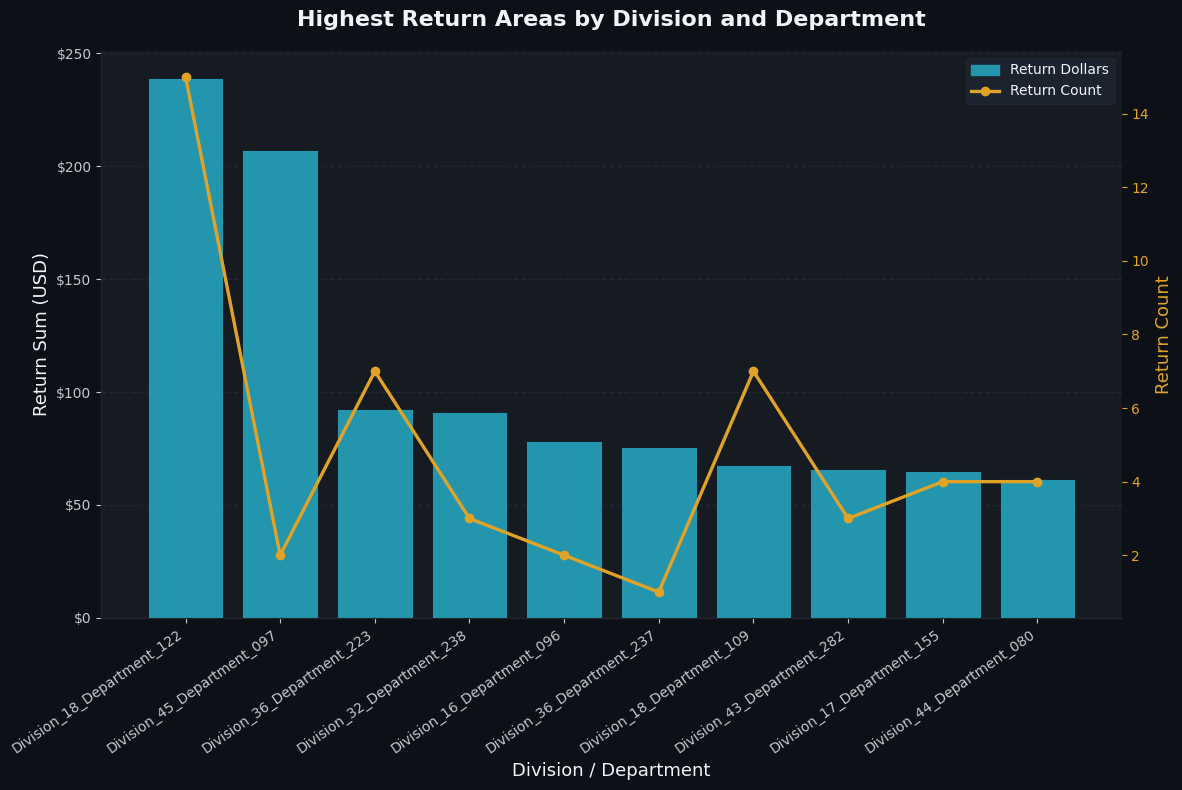

In [23]:
# Returns view visualisation
df_view['Division_Department'] = df_view['Division_Name'] + '_' + df_view['Department_Name']
df_view['Return_Sum_Dollars_Abs'] = df_view['Return_Sum_Dollars'].abs()
plot_data = df_view.sort_values('Return_Sum_Dollars_Abs', ascending=False).reset_index(drop=True)
indices = np.arange(len(plot_data))

fig, ax1 = plt.subplots(figsize=(12, 8), dpi=100)
fig.patch.set_facecolor(SITE_BG)
apply_axes_theme(ax1)
ax1.grid(axis='y', linestyle='--', linewidth=1.0, alpha=0.5)

bars = ax1.bar(
    indices,
    plot_data['Return_Sum_Dollars_Abs'],
    color=PRIMARY_COLOR,
    edgecolor="#101820",
    linewidth=0.6,
    zorder=3,
)
ax1.set_xlabel('Division / Department')
ax1.set_ylabel('Return Sum (USD)')
ax1.yaxis.set_major_formatter(currency_formatter())
ax1.set_xticks(indices)
ax1.set_xticklabels(plot_data['Division_Department'], rotation=35, ha='right')

ax2 = ax1.twinx()
ax2.set_facecolor(SURFACE_COLOR)
ax2.spines['right'].set_color(BORDER_COLOR)
ax2.tick_params(axis='y', colors=ACCENT_COLOR)
line, = ax2.plot(
    indices,
    plot_data['Return_Sum_Count'],
    color=ACCENT_COLOR,
    marker='o',
    linewidth=2.4,
    markersize=6,
    zorder=4,
    label='Return Count',
)
ax2.set_ylabel('Return Count', color=ACCENT_COLOR)

ax1.set_title('Highest Return Areas by Division and Department', pad=18)
legend_handles = [
    mpatches.Patch(color=PRIMARY_COLOR, label='Return Dollars'),
    Line2D([0], [0], color=ACCENT_COLOR, marker='o', linewidth=2.4, label='Return Count'),
]
style_legend(ax1.legend(handles=legend_handles, loc='upper right'))

plt.tight_layout()
plt.show()


## Results & Conclusions
### Key Findings:
Security Incidents Across Store Formats: StoreFormat_47 exhibited the highest average security incidents per store. It is critical that additional security measures are implemented in these stores to curb incidents and maintain a safe environment for customers and staff.

States with Highest Theft: The states with the most alarming rates of average recorded daily theft are State_38, State_03, and State_20. It appears that loss prevention measures may need to be concentrated more intensively in these geographical areas.

Impact of Recent Boycott on Sales: There is substantial evidence to suggest that the recent boycotts are affecting store performance. Sales have been in decline year-over-year, but a sharp decline is observed in 2023, with the month of July experiencing a drastic 60.18% drop in sales compared to the same month in the previous year.

Employee Reporting of Empty Packages: Employees with IDs 231, 098, and 196 have reported the highest number of empty packages for the current month. The data also indicates that high-value items may be more susceptible to theft or loss, as inferred from the high retail sum despite a low item count reported by Employee 098.
### Recommendations:
Allocate More Security Resources: Given the high rate of security incidents at StoreFormat_47 locations, it would be advisable to allocate more security resources, both human and technological, to these stores.

Targeted Loss Prevention: With States 38, 03, and 20 facing higher theft averages, loss prevention initiatives should focus more on these regions. This may include installing advanced security systems and conducting frequent security audits.

Investigate the Impact of Boycotts: The drastic drop in sales indicates that the boycott is affecting store performance. A thorough analysis of customer sentiment and public relations effectiveness should be conducted to formulate strategies to reverse this trend.

Investigate Employee Reports: Given the high reporting of empty packages by specific employees, it might be beneficial to dig deeper into the circumstances around these reports. This includes both recognizing the vigilance of these employees and understanding whether these specific store sections are more prone to theft or loss.